In [1]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional
#para o primeiro algoritmo
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Carrega o dataset de treino
data_train = pd.read_csv('treino.csv')
data_train.head()

,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference
0,50,female,38091,bachelor,3,hiking,1308,rural,41,85,spring,0,0,1
1,47,non-binary,50274,high school,6,hiking,2306,urban,239,218,summer,0,1,0
2,41,female,43443,doctorate,8,sunbathing,2351,rural,222,173,winter,1,0,0
3,69,non-binary,62584,doctorate,9,sunbathing,1068,urban,140,76,summer,0,1,0
4,68,male,55805,bachelor,1,sunbathing,4704,suburban,296,201,winter,1,1,0


In [3]:
# Criação de Features de treino
data_train['Average_Proximity'] = (data_train['Proximity_to_Mountains'] + data_train['Proximity_to_Beaches']) / 2
data_train['Total_Travel_Expenditure'] = data_train['Travel_Frequency'] * data_train['Vacation_Budget']
data_train['Income_Per_Age'] = data_train['Income'] / data_train['Age']
data_train['Is_Graduate'] = data_train['Education_Level'].apply(lambda x: 1 if x in ['bachelor', 'master', 'doctorate'] else 0)


In [4]:
# Criação de novas features
data_train['Income_Age_Ratio'] = data_train['Income'] / data_train['Age']
data_train['Budget_Per_Trip'] = data_train['Vacation_Budget'] / (data_train['Travel_Frequency'] + 1)
data_train['Total_Distance'] = data_train['Proximity_to_Mountains'] + data_train['Proximity_to_Beaches']
data_train['Travel_Frequency_Budget_Interaction'] = data_train['Travel_Frequency'] * data_train['Vacation_Budget']


In [5]:
# Classificação da renda em categorias
bins = [0, 30000, 60000, 90000, np.inf]
labels = ['Baixa', 'Média', 'Alta', 'Muito Alta']
data_train['Income_Category'] = pd.cut(data_train['Income'], bins=bins, labels=labels)

In [6]:
# Carrega o dataset de teste
data_test = pd.read_csv('teste.csv')
data_test.head()

,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference
0,31,non-binary,45179,high school,3,sunbathing,959,suburban,173,154,summer,1,0,0
1,51,male,47442,bachelor,5,hiking,756,suburban,8,289,summer,0,1,1
2,26,male,92894,high school,0,sunbathing,804,rural,287,203,winter,1,0,0
3,58,male,104297,doctorate,5,skiing,2143,urban,286,84,summer,1,0,0
4,56,male,95662,high school,2,swimming,4627,suburban,299,121,spring,0,0,0


In [7]:
# Criação de Features de teste
data_test['Average_Proximity'] = (data_test['Proximity_to_Mountains'] + data_test['Proximity_to_Beaches']) / 2
data_test['Total_Travel_Expenditure'] = data_test['Travel_Frequency'] * data_test['Vacation_Budget']
data_test['Income_Per_Age'] = data_test['Income'] / data_test['Age']
data_test['Is_Graduate'] = data_test['Education_Level'].apply(lambda x: 1 if x in ['bachelor', 'master', 'doctorate'] else 0)

In [8]:
# Criação de novas features para o conjunto de teste (repita as mesmas operações)
data_test['Income_Age_Ratio'] = data_test['Income'] / data_test['Age']
data_test['Budget_Per_Trip'] = data_test['Vacation_Budget'] / (data_test['Travel_Frequency'] + 1)
data_test['Total_Distance'] = data_test['Proximity_to_Mountains'] + data_test['Proximity_to_Beaches']
data_test['Travel_Frequency_Budget_Interaction'] = data_test['Travel_Frequency'] * data_test['Vacation_Budget']
data_test['Income_Category'] = pd.cut(data_test['Income'], bins=bins, labels=labels)

In [9]:
# Verifica a dimensão dos dados de treino e teste
print(f'Dimensão dos dados de treino: {data_train.shape}\n')
print(f'Dimensão dos dados de teste: {data_test.shape}\n')

Dimensão dos dados de treino: (41955, 23)

Dimensão dos dados de teste: (10489, 23)



In [10]:
# Início da normalização de todos os dados
# Identificando colunas numéricas e categóricas
numeric_cols = data_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data_train.select_dtypes(include=['object']).columns.tolist()

In [11]:
# Inicializando o scaler
scaler = StandardScaler()

In [12]:
# Normalizando os dados numéricos de treino , com o Z-Score Normalization ou Standardization.
data_train[numeric_cols] = scaler.fit_transform(data_train[numeric_cols])

In [13]:
# Normalizando os dados numéricos de teste (usando os parâmetros do treino) 
data_test[numeric_cols] = scaler.transform(data_test[numeric_cols])

In [14]:
# Aplicar One-Hot Encoding nas variáveis categóricas de treino e teste
data_train = pd.get_dummies(data_train, columns=categorical_cols, drop_first=True)
data_test = pd.get_dummies(data_test, columns=categorical_cols, drop_first=True)

In [15]:
# Garantir que as colunas nos conjuntos de treino e teste sejam as mesmas
data_train, data_test = data_train.align(data_test, join='left', axis=1, fill_value=0)

In [16]:
# Verificando a normalização e a codificação 
print("Dados de treino após normalização e One-Hot Encoding:")
print(data_train.describe())

print("Dados de teste após normalização e One-Hot Encoding:")
print(data_test.describe())

Dados de treino após normalização e One-Hot Encoding:
                Age        Income  Travel_Frequency  Vacation_Budget  \
count  4.195500e+04  4.195500e+04      4.195500e+04     4.195500e+04   
mean   1.837538e-16  1.551322e-16     -1.060183e-16    -1.639388e-16   
std    1.000012e+00  1.000012e+00      1.000012e+00     1.000012e+00   
min   -1.700900e+00 -1.734286e+00     -1.558638e+00    -1.726222e+00   
25%   -8.332772e-01 -8.663466e-01     -8.637549e-01    -8.632533e-01   
50%   -3.239419e-02  1.731704e-03     -1.688720e-01    -1.031055e-02   
75%    8.352290e-01  8.694455e-01      8.734523e-01     8.692385e-01   
max    1.702852e+00  1.736986e+00      1.568335e+00     1.743389e+00   

       Proximity_to_Mountains  Proximity_to_Beaches          Pets  \
count            4.195500e+04          4.195500e+04  4.195500e+04   
mean            -1.583500e-16          1.366721e-16 -2.133915e-17   
std              1.000012e+00          1.000012e+00  1.000012e+00   
min             -1.73

In [17]:
# Função para visualizar dados numéricos e categóricos do conjunto de dados
def analise_grafica(dataframe, dataset_name="Dataset"):
    # Separar colunas numéricas e categóricas
    numeric_columns = dataframe.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns
    
    print(f"Análise Gráfica para {dataset_name}")
    
    # Histograma para variáveis numéricas
    dataframe[numeric_columns].hist(bins=20, figsize=(15, 10))
    plt.suptitle(f'Distribuição das Variáveis Numéricas - {dataset_name}', fontsize=16)
    plt.show()

    # Gráficos de barras para variáveis categóricas
    num_cols = 3  # Número de colunas na plotagem
    num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Número de linhas necessárias
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(categorical_columns):
        sns.countplot(data=dataframe, x=col, ax=axes[i], palette="muted", hue=col, dodge=False, legend=False)
        axes[i].set_title(f'Distribuição de {col}')
        axes[i].tick_params(axis='x', rotation=45)

    # Remover subplots não utilizados
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Heatmap de correlação para variáveis numéricas
    plt.figure(figsize=(12, 10))
    sns.heatmap(dataframe[numeric_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f'Mapa de Correlação das Variáveis Numéricas - {dataset_name}')
    plt.show()

### Explicação dos Termos Estatísticos

- **count**: Número total de observações não nulas para a coluna.
- **unique**: Número de valores únicos na coluna (somente para dados categóricos).
- **top**: O valor mais frequente (somente para dados categóricos).
- **freq**: Frequência do valor mais frequente (somente para dados categóricos).
- **mean**: Média aritmética dos valores (somente para dados numéricos).
- **std**: Desvio padrão dos valores, indicando a dispersão em torno da média (somente para dados numéricos).
- **min**: Valor mínimo encontrado na coluna (somente para dados numéricos).
- **25% (1º quartil)**: O valor abaixo do qual 25% dos dados estão (somente para dados numéricos).
- **50% (mediana)**: O valor central que divide os dados em duas partes iguais (somente para dados numéricos).
- **75% (3º quartil)**: O valor abaixo do qual 75% dos dados estão (somente para dados numéricos).
- **max**: Valor máximo encontrado na coluna (somente para dados numéricos).

In [18]:
# Estatísticas sobre as variáveis numéricas de treino
data_train.describe()

,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Pets,Environmental_Concerns,Preference,Average_Proximity,Total_Travel_Expenditure,Income_Per_Age,Is_Graduate,Income_Age_Ratio,Budget_Per_Trip,Total_Distance,Travel_Frequency_Budget_Interaction
count,4.195500e+04,4.195500e+04,4.195500e+04,4.195500e+04,4.195500e+04,4.195500e+04,4.195500e+04,4.195500e+04,4.195500e+04,4.195500e+04,4.195500e+04,4.195500e+04,4.195500e+04,4.195500e+04,4.195500e+04,4.195500e+04,4.195500e+04
mean,1.837538e-16,1.551322e-16,-1.060183e-16,-1.639388e-16,-1.583500e-16,1.366721e-16,-2.133915e-17,1.159046e-16,9.653423e-18,2.156778e-16,-5.775118e-17,2.960383e-16,-1.016150e-18,2.960383e-16,1.016997e-16,2.156778e-16,-5.775118e-17
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-1.700900e+00,-1.734286e+00,-1.558638e+00,-1.726222e+00,-1.736338e+00,-1.732266e+00,-1.000835e+00,-9.984995e-01,-5.780567e-01,-2.457168e+00,-1.168099e+00,-1.395780e+00,-1.736991e+00,-1.395780e+00,-8.539349e-01,-2.457168e+00,-1.168099e+00
25%,-8.332772e-01,-8.663466e-01,-8.637549e-01,-8.632533e-01,-8.695782e-01,-8.650622e-01,-1.000835e+00,-9.984995e-01,-5.780567e-01,-7.129198e-01,-7.969121e-01,-7.341841e-01,5.757081e-01,-7.341841e-01,-5.799528e-01,-7.129198e-01,-7.969121e-01
50%,-3.239419e-02,1.731704e-03,-1.688720e-01,-1.031055e-02,8.738599e-03,2.141397e-03,9.991661e-01,-9.984995e-01,-5.780567e-01,-8.669307e-03,-2.738329e-01,-2.179429e-01,5.757081e-01,-2.179429e-01,-3.469423e-01,-8.669307e-03,-2.738329e-01
75%,8.352290e-01,8.694455e-01,8.734523e-01,8.692385e-01,8.639418e-01,8.577823e-01,9.991661e-01,1.001503e+00,1.729934e+00,7.201480e-01,6.114620e-01,4.584946e-01,5.757081e-01,4.584946e-01,1.238608e-01,7.201480e-01,6.114620e-01
max,1.702852e+00,1.736986e+00,1.568335e+00,1.743389e+00,1.719145e+00,1.724986e+00,9.991661e-01,1.001503e+00,1.729934e+00,2.423451e+00,3.102164e+00,4.286822e+00,5.757081e-01,4.286822e+00,4.739448e+00,2.423451e+00,3.102164e+00


Análise Gráfica para treino.csv


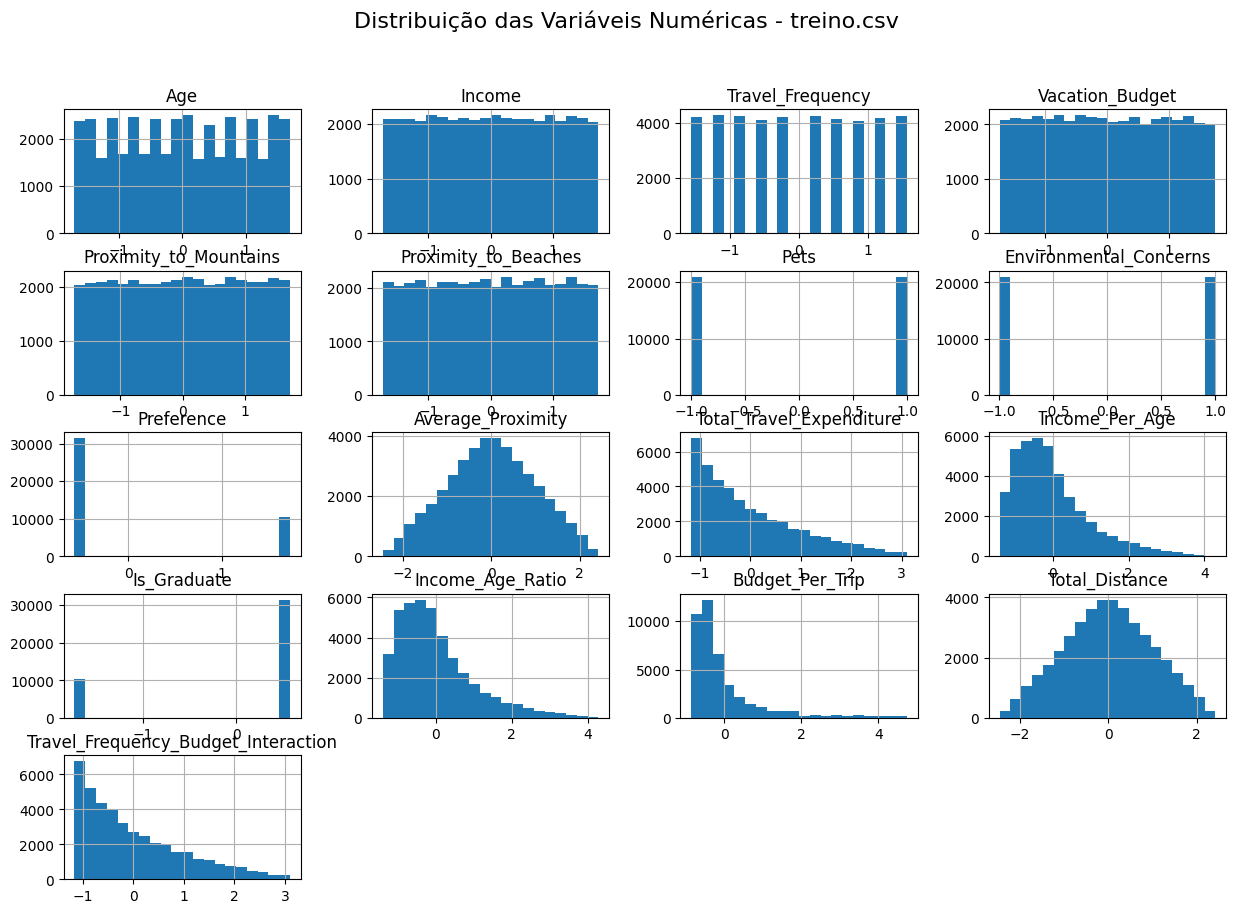

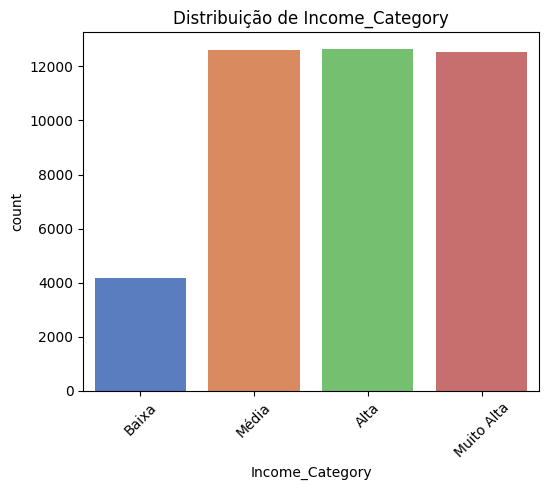

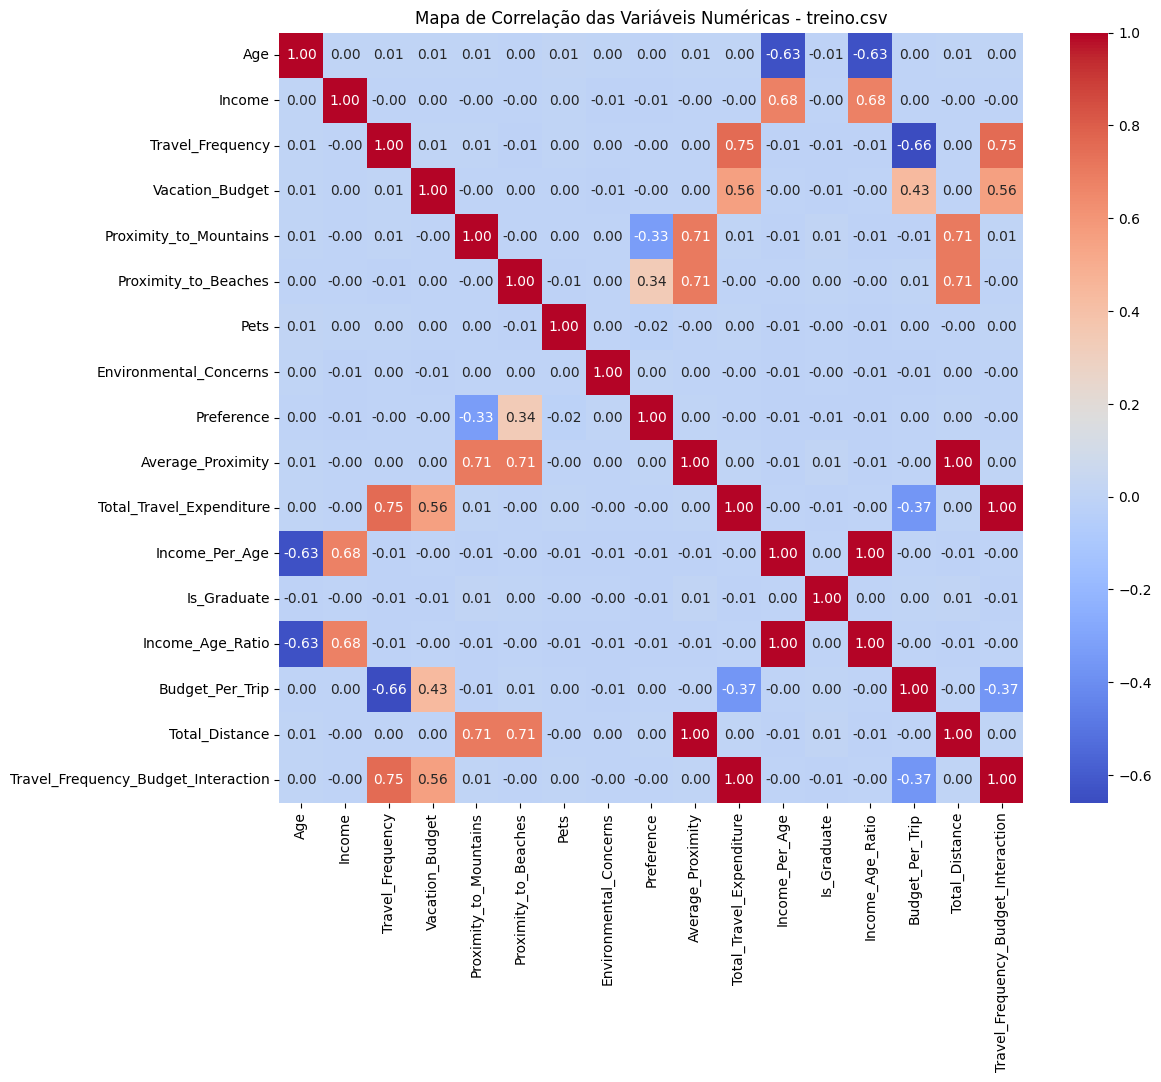

In [19]:
# Análise gráfca do treino
analise_grafica(data_train, "treino.csv")

In [20]:
# Estatísticas sobre as variáveis numéricas de teste
data_test.describe()

,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Pets,Environmental_Concerns,Preference,Average_Proximity,Total_Travel_Expenditure,Income_Per_Age,Is_Graduate,Income_Age_Ratio,Budget_Per_Trip,Total_Distance,Travel_Frequency_Budget_Interaction
count,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000
mean,0.007336,0.009573,0.005594,0.013224,-0.017355,0.004258,0.004409,-0.008128,0.002847,-0.009282,0.008339,0.005241,-0.003735,0.005241,0.004862,-0.009282,0.008339
std,1.000691,1.007030,0.996416,1.000837,1.001006,0.999088,1.000034,1.000002,1.001682,1.007373,0.995584,1.008512,1.002207,1.008512,1.016502,1.007373,0.995584
min,-1.700900,-1.734355,-1.558638,-1.726222,-1.736338,-1.732266,-1.000835,-0.998500,-0.578057,-2.424412,-1.168099,-1.386263,-1.736991,-1.386263,-0.853709,-2.424412,-1.168099
25%,-0.833277,-0.861261,-0.863755,-0.847829,-0.892692,-0.841937,-1.000835,-0.998500,-0.578057,-0.729298,-0.796343,-0.732815,-1.736991,-0.732815,-0.580689,-0.729298,-0.796343
50%,-0.032394,0.028705,0.178569,0.014368,-0.014375,0.002141,0.999166,-0.998500,-0.578057,-0.008669,-0.251429,-0.208518,0.575708,-0.208518,-0.346063,-0.008669,-0.251429
75%,0.901969,0.884234,0.873452,0.881192,0.852385,0.880908,0.999166,1.001503,1.729934,0.711959,0.614737,0.469494,0.575708,0.469494,0.122221,0.711959,0.614737
max,1.702852,1.736847,1.568335,1.742618,1.719145,1.724986,0.999166,1.001503,1.729934,2.407074,3.096183,4.275759,0.575708,4.275759,4.742841,2.407074,3.096183


Análise Gráfica para teste.csv


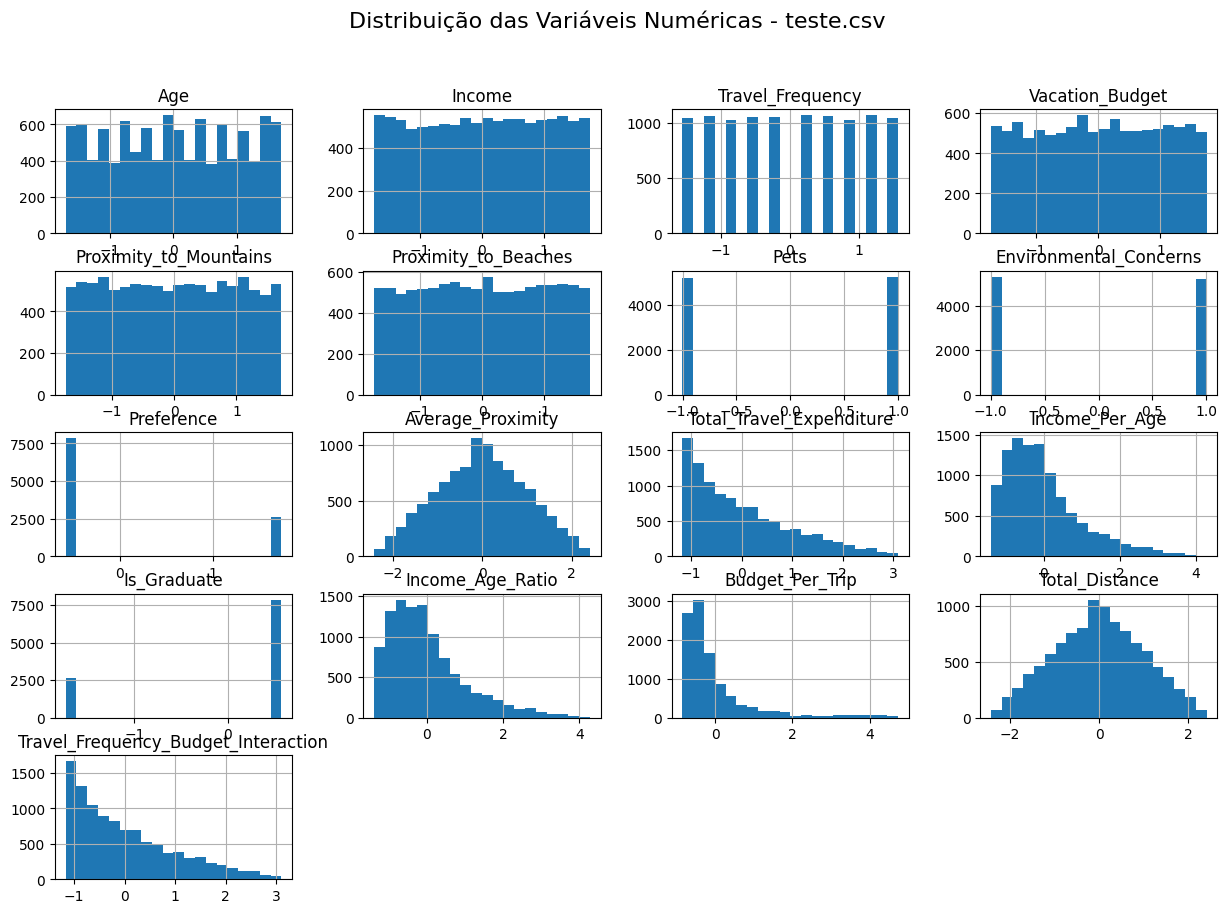

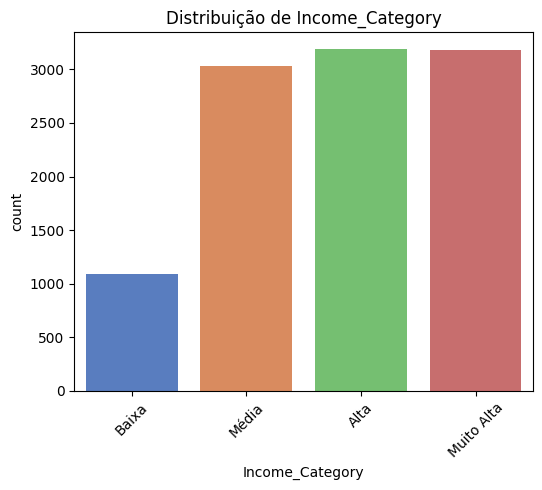

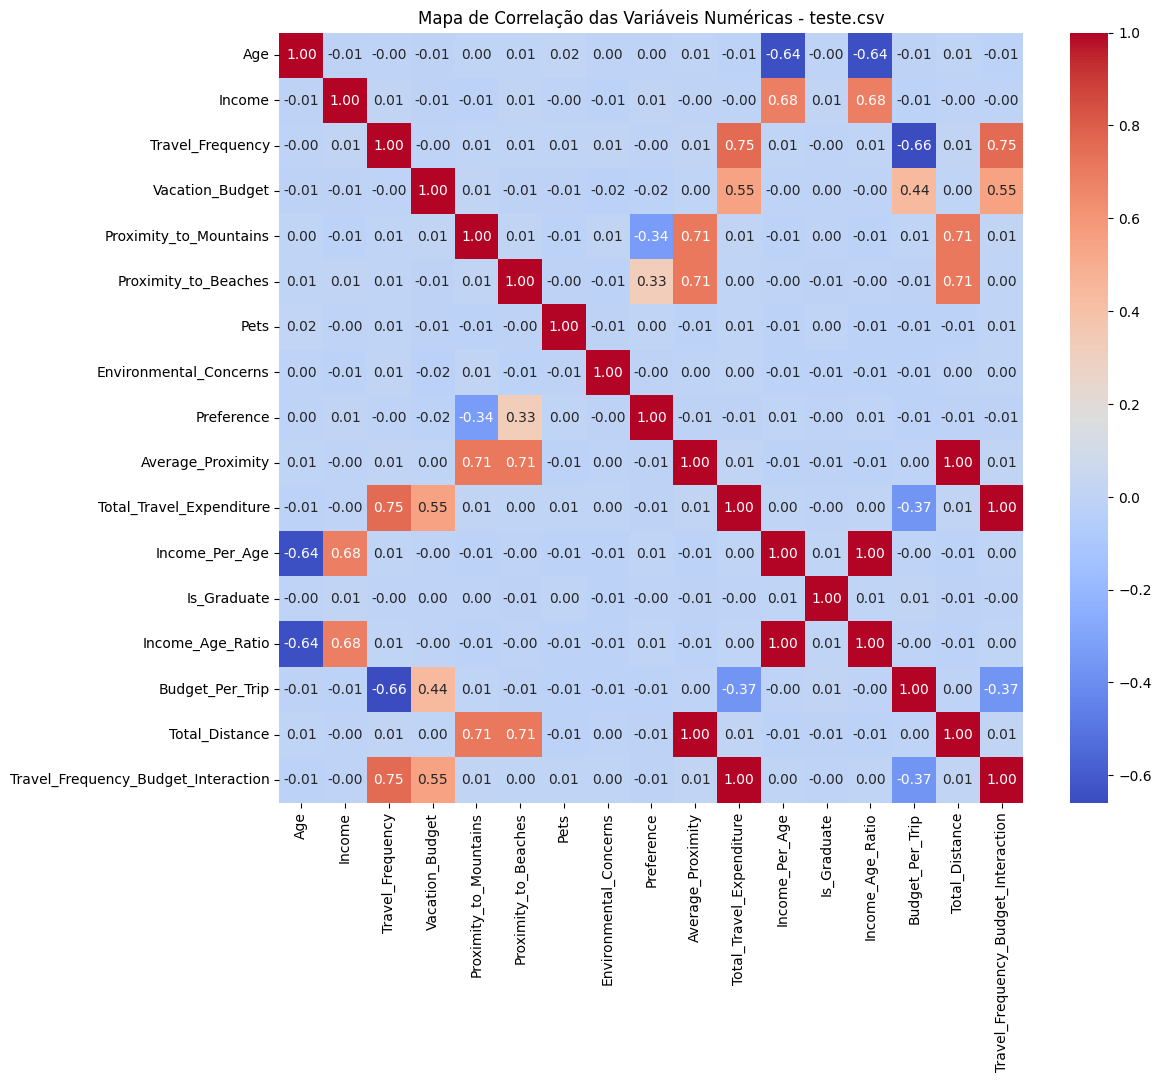

In [21]:
# Análise gráfca do teste
analise_grafica(data_test, "teste.csv")

In [22]:
# Lista de variáveis categóricas
colunas_cat = data_train.select_dtypes(include=['object']).columns.tolist()

# Estatísticas sobre as variáveis categóricas
for coluna in colunas_cat:
    print(f'### Coluna <{coluna}> ###')
    print(data_train[coluna].value_counts())
    print('-' * 40)

In [23]:
# Lista de variáveis categóricas
colunas_cat = data_test.select_dtypes(include=['object']).columns.tolist()

# Estatísticas sobre as variáveis categóricas
for coluna in colunas_cat:
    print(f'### Coluna <{coluna}> ###')
    print(data_test[coluna].value_counts())
    print('-' * 40)

In [24]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41955 entries, 0 to 41954
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Age                                  41955 non-null  float64 
 1   Income                               41955 non-null  float64 
 2   Travel_Frequency                     41955 non-null  float64 
 3   Vacation_Budget                      41955 non-null  float64 
 4   Proximity_to_Mountains               41955 non-null  float64 
 5   Proximity_to_Beaches                 41955 non-null  float64 
 6   Pets                                 41955 non-null  float64 
 7   Environmental_Concerns               41955 non-null  float64 
 8   Preference                           41955 non-null  float64 
 9   Average_Proximity                    41955 non-null  float64 
 10  Total_Travel_Expenditure             41955 non-null  float64 
 11  Income_Per_Age 

In [25]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10489 entries, 0 to 10488
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Age                                  10489 non-null  float64 
 1   Income                               10489 non-null  float64 
 2   Travel_Frequency                     10489 non-null  float64 
 3   Vacation_Budget                      10489 non-null  float64 
 4   Proximity_to_Mountains               10489 non-null  float64 
 5   Proximity_to_Beaches                 10489 non-null  float64 
 6   Pets                                 10489 non-null  float64 
 7   Environmental_Concerns               10489 non-null  float64 
 8   Preference                           10489 non-null  float64 
 9   Average_Proximity                    10489 non-null  float64 
 10  Total_Travel_Expenditure             10489 non-null  float64 
 11  Income_Per_Age 

In [26]:
# Verificando dados nulos do treino
print('Colunas com dados nulos:')
display(data_train.isnull().sum()[data_train.isnull().sum() > 0])

Colunas com dados nulos:


Series([], dtype: int64)

In [27]:
# Verificando dados nulos do teste
print('Colunas com dados nulos:')
display(data_test.isnull().sum()[data_test.isnull().sum() > 0])

Colunas com dados nulos:


Series([], dtype: int64)

In [28]:
# Definir a conversão para variáveis categóricas ordinais
conversao_variaveis = {
    'Gender': {
        'non-binary': 0,
        'female': 1,
        'male': 2
    },
    'Education_Level': {
        'high school': 1,
        'bachelor': 2,
        'master': 3,
        'doctorate': 4
    },
    'Preferred_Activities': {
        'hiking': 1,
        'skiing': 2,
        'swimming': 3,
        'sunbathing': 4
    },
    'Location': {
        'rural': 1,
        'suburban': 2,
        'urban': 3
    },
    'Favorite_Season': {
        'spring': 1,
        'fall': 2,
        'winter': 3,
        'summer': 4
    },
    'Pets': {
        0: 'No',  
        1: 'Yes'  
    },
    'Environmental_Concerns': {
        0: 'No',  
        1: 'Yes'  
    }
}

# Aplicar a conversão
data_train.replace(conversao_variaveis, inplace=True)
data_test.replace(conversao_variaveis, inplace=True)

# Visualizar uma amostra para confirmar a conversão
data_train.sample(5)
data_test.sample(5)


,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Pets,Environmental_Concerns,Preference,Average_Proximity,...,Education_Level_high school,Education_Level_master,Preferred_Activities_skiing,Preferred_Activities_sunbathing,Preferred_Activities_swimming,Location_suburban,Location_urban,Favorite_Season_spring,Favorite_Season_summer,Favorite_Season_winter
9030,0.368047,1.360650,-0.168872,-1.176359,-1.135385,-0.656933,0.999166,-0.998500,-0.578057,-1.269769,...,True,False,False,False,True,False,True,False,True,False
4966,1.302411,-0.261193,0.873452,0.027478,-0.465090,1.539982,0.999166,-0.998500,1.729934,0.761093,...,False,False,False,False,False,False,False,True,False,False
105,1.502631,1.054472,-1.211196,1.627710,0.679033,-1.327571,0.999166,-0.998500,-0.578057,-0.459062,...,False,False,False,False,True,True,False,True,False,False
8274,-0.165875,0.730971,0.873452,-0.637293,1.002623,0.083080,0.999166,1.001503,-0.578057,0.769282,...,False,False,False,False,True,True,False,True,False,False
5601,-0.499576,0.089906,-0.516313,-0.235500,-0.199284,1.713423,-1.000835,1.001503,1.729934,1.072273,...,False,False,False,False,False,False,True,False,False,False


In [29]:
# Listar as variáveis categóricas (excluindo a variável alvo, se for categórica)
cols_cat_train = data_train.select_dtypes(include='object').columns.tolist()
cols_cat_test = data_train.select_dtypes(include='object').columns.tolist()

# Aplicar OneHotEncoding nas variáveis categóricas de treino e teste
data_train = pd.get_dummies(data_train, columns=cols_cat_train, drop_first=True)
data_test = pd.get_dummies(data_test, columns=cols_cat_test, drop_first=True)

# Garantir que as colunas nos conjuntos de treino e teste sejam as mesmas
# Isso é útil caso algumas categorias estejam ausentes em um dos conjuntos
data_train, data_test = data_train.align(data_test, join='left', axis=1, fill_value=0)

# Exibir uma amostra dos dados para verificar o resultado
print("Amostra dos dados de treino com OneHotEncoding:")
display(data_train.head())

print("Amostra dos dados de teste com OneHotEncoding:")
display(data_test.head())

Amostra dos dados de treino com OneHotEncoding:


,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Pets,Environmental_Concerns,Preference,Average_Proximity,...,Education_Level_high school,Education_Level_master,Preferred_Activities_skiing,Preferred_Activities_sunbathing,Preferred_Activities_swimming,Location_suburban,Location_urban,Favorite_Season_spring,Favorite_Season_summer,Favorite_Season_winter
0,0.434788,-1.106377,-0.516313,-1.103095,-1.262509,-0.749435,-1.000835,-0.998500,1.729934,-1.425359,...,False,False,False,False,False,False,False,True,False,False
1,0.234567,-0.683455,0.526011,-0.333442,1.025737,0.788406,-1.000835,1.001503,-0.578057,1.285186,...,True,False,False,False,False,False,True,False,True,False
2,-0.165875,-0.920587,1.220894,-0.298738,0.829271,0.268084,0.999166,-0.998500,-0.578057,0.777471,...,False,False,False,True,False,False,False,False,False,True
3,1.702852,-0.256125,1.568335,-1.288182,-0.118386,-0.853499,-1.000835,1.001503,-0.578057,-0.688353,...,False,False,False,True,False,False,True,False,True,False
4,1.636112,-0.491452,-1.211196,1.515886,1.684475,0.591840,0.999166,1.001503,-0.578057,1.612745,...,False,False,False,True,False,True,False,False,False,True


Amostra dos dados de teste com OneHotEncoding:


,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Pets,Environmental_Concerns,Preference,Average_Proximity,...,Education_Level_high school,Education_Level_master,Preferred_Activities_skiing,Preferred_Activities_sunbathing,Preferred_Activities_swimming,Location_suburban,Location_urban,Favorite_Season_spring,Favorite_Season_summer,Favorite_Season_winter
0,-0.833277,-0.860324,-0.516313,-1.372243,0.262988,0.048392,0.999166,-0.998500,-0.578057,0.220622,...,True,False,False,True,False,True,False,False,True,False
1,0.501528,-0.781766,0.178569,-1.528795,-1.643884,1.609359,-1.000835,1.001503,1.729934,-0.025047,...,False,False,False,False,False,True,False,False,True,False
2,-1.166978,0.796060,-1.558638,-1.491778,1.580463,0.614965,0.999166,-0.998500,-0.578057,1.555422,...,True,False,False,True,False,False,False,False,False,True
3,0.968710,1.191905,0.178569,-0.459147,1.568907,-0.760998,0.999166,-0.998500,-0.578057,0.572747,...,False,False,True,False,False,False,True,False,True,False
4,0.835229,0.892149,-0.863755,1.456504,1.719145,-0.333177,-1.000835,-0.998500,-0.578057,0.982195,...,True,False,False,False,True,True,False,True,False,False


In [30]:
print("Valores nulos do treino")

# Imputando os valores nulos com a média
data_train = data_train.fillna(data_train.mean())

# Verifica valores nulos novamente
data_train.isnull().sum()

Valores nulos do treino


TypeError: 'Categorical' with dtype category does not support reduction 'mean'

In [ ]:
print("Valores nulos do teste")

# Imputando os valores nulos com a média
data_test = data_test.fillna(data_test.mean())

# Verifica valores nulos novamente
data_test.isnull().sum()

Valores nulos do teste


Age                           0
Gender                        0
Income                        0
Education_Level               0
Travel_Frequency              0
Preferred_Activities          0
Vacation_Budget               0
Location                      0
Proximity_to_Mountains        0
Proximity_to_Beaches          0
Favorite_Season               0
Preference                    0
Average_Proximity             0
Total_Travel_Expenditure      0
Income_Per_Age                0
Is_Graduate                   0
Pets_Yes                      0
Environmental_Concerns_Yes    0
dtype: int64

In [ ]:
# Separar as variáveis independentes (X) e dependente (y) nos conjuntos de treino e teste
X = data_train.drop(columns=['Preference'])
y = data_train['Preference']

# Dividir os dados em treino e teste com stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Verificar as proporções de classes no conjunto de treino
print("### Proporção de Classes em Treino ###")
print(f"Porcentagem de entradas Classe 0: {y_train.value_counts(normalize=True).values[0] * 100:.2f}%")
print(f"Porcentagem de entradas Classe 1: {y_train.value_counts(normalize=True).values[1] * 100:.2f}%")
print()

# Verificar as proporções de classes no conjunto de teste
print("### Proporção de Classes em Teste ###")
print(f"Porcentagem de entradas Classe 0: {y_test.value_counts(normalize=True).values[0] * 100:.2f}%")
print(f"Porcentagem de entradas Classe 1: {y_test.value_counts(normalize=True).values[1] * 100:.2f}%")

### Proporção de Classes em Treino ###
Porcentagem de entradas Classe 0: 74.96%
Porcentagem de entradas Classe 1: 25.04%

### Proporção de Classes em Teste ###
Porcentagem de entradas Classe 0: 74.95%
Porcentagem de entradas Classe 1: 25.05%


In [ ]:
# Análise e Tratamento de Valores Faltantes
def preprocess_data(data):
    imputer = SimpleImputer(strategy='most_frequent')
    data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    
    # Codificação de variáveis categóricas
    data = pd.get_dummies(data, columns=['Gender', 'Education_Level', 'Preferred_Activities', 'Location', 'Favorite_Season'], drop_first=True)
    
    # Normalização das features numéricas
    scaler = StandardScaler()
    numeric_features = ['Age', 'Income', 'Travel_Frequency', 'Vacation_Budget', 'Proximity_to_Mountains', 'Proximity_to_Beaches']
    data[numeric_features] = scaler.fit_transform(data[numeric_features])
    
    return data

In [ ]:
# Pré-processar dados de treino e teste
data_train = preprocess_data(data_train)
data_test = preprocess_data(data_test)

# Separando features e target
X_train = data_train.drop(columns=['Preference'])
y_train = data_train['Preference']
X_test = data_test.drop(columns=['Preference'])
y_test = data_test['Preference']

# Seleção de features
selector = SelectKBest(f_classif, k=10)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

# Obter os nomes das colunas selecionadas
selected_columns = data_train.drop(columns=['Preference']).columns[selector.get_support()]

# Transformar X_train e X_test de volta em DataFrames
X_train = pd.DataFrame(X_train, columns=selected_columns)
X_test = pd.DataFrame(X_test, columns=selected_columns)

In [ ]:
def performance_modelo_classificacao(model, X_train, X_test, y_train, y_test, flag=True):
    # Lista para armazenar os resultados de Treino e Teste
    score_list = []

    # Predição em Treino e Teste
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    # Acurácia do modelo
    train_acc = accuracy_score(y_train, pred_train)
    test_acc = accuracy_score(y_test, pred_test)

    # Recall do modelo
    train_recall = recall_score(y_train, pred_train)
    test_recall = recall_score(y_test, pred_test)

    # Precisão do modelo
    train_prec = precision_score(y_train, pred_train)
    test_prec = precision_score(y_test, pred_test)

    # F1-Score do modelo
    train_f1 = f1_score(y_train, pred_train)
    test_f1 = f1_score(y_test, pred_test)

    # Popula a lista
    score_list.extend((train_acc, test_acc, train_recall, test_recall, train_prec, test_prec, train_f1, test_f1))

    # Imprime os resultados se flag=True
    if flag:
        print(f'Acurácia na base de Treino: {train_acc:.4f}')
        print(f'Acurácia na base de Teste: {test_acc:.4f}')
        print(f'\nRecall na base de Treino: {train_recall:.4f}')
        print(f'Recall na base de Teste: {test_recall:.4f}')
        print(f'\nPrecisão na base de Treino: {train_prec:.4f}')
        print(f'Precisão na base de Teste: {test_prec:.4f}')
        print(f'\nF1-Score na base de Treino: {train_f1:.4f}')
        print(f'F1-Score na base de Teste: {test_f1:.4f}')

    # Retorna a lista de valores de métricas para Treino e Teste
    return score_list

In [ ]:
# Função para exibir a matriz de confusão
def matriz_confusao(model, X, y_actual, labels=(1, 0)):
    y_predict = model.predict(X)
    cm = confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index=['Real - Não (0)', 'Real - Sim (1)'],
                         columns=['Previsto - Não (0)', 'Previsto - Sim (1)'])
    group_counts = [f'{value:.0f}' for value in cm.flatten()]
    group_percentages = [f'{value:.2f}%' for value in (cm.flatten() / np.sum(cm)) * 100]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Classe Prevista', fontweight='bold')
    plt.ylabel('Classe Real', fontweight='bold')
    plt.show()

In [ ]:
# Instanciando o modelo de Árvore de Decisão
arvore_d = DecisionTreeClassifier(criterion="entropy", random_state=1)

# Treinando o modelo
arvore_d.fit(X_train, y_train)

# Avaliando o modelo no conjunto de treino e teste
print("### Avaliação do Modelo de Árvore de Decisão ###")
arvore_d_scores = performance_modelo_classificacao(arvore_d, X_train, X_test, y_train, y_test)

### Avaliação do Modelo de Árvore de Decisão ###
Acurácia na base de Treino: 1.0000
Acurácia na base de Teste: 0.9969

Recall na base de Treino: 1.0000
Recall na base de Teste: 0.9905

Precisão na base de Treino: 1.0000
Precisão na base de Teste: 0.9970

F1-Score na base de Treino: 1.0000
F1-Score na base de Teste: 0.9937


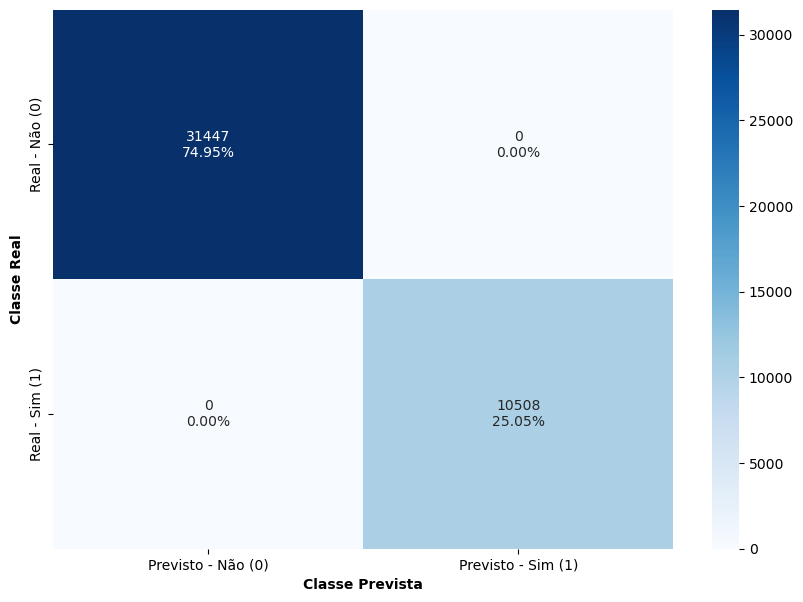

In [ ]:
# Matriz de Confusão de treino
matriz_confusao(arvore_d, X_train, y_train)

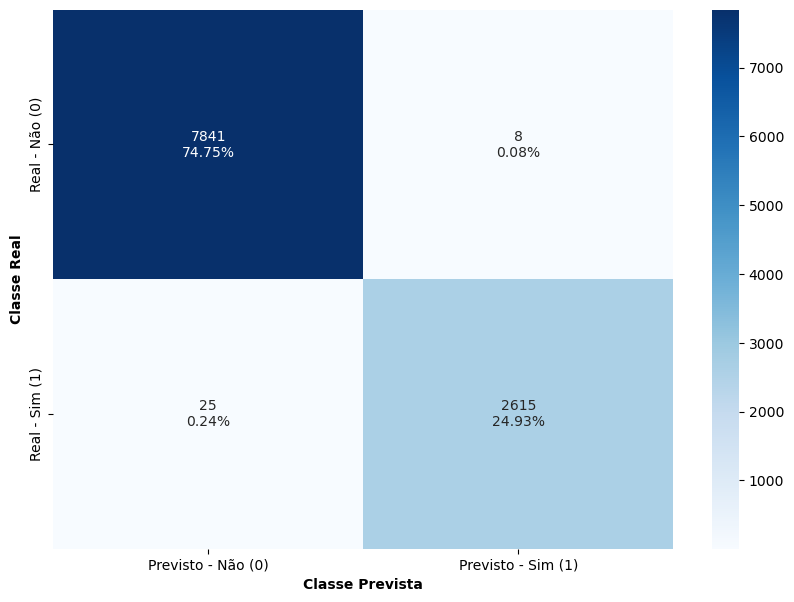

In [ ]:
# Matriz de Confusão de teste
matriz_confusao(arvore_d, X_test, y_test)

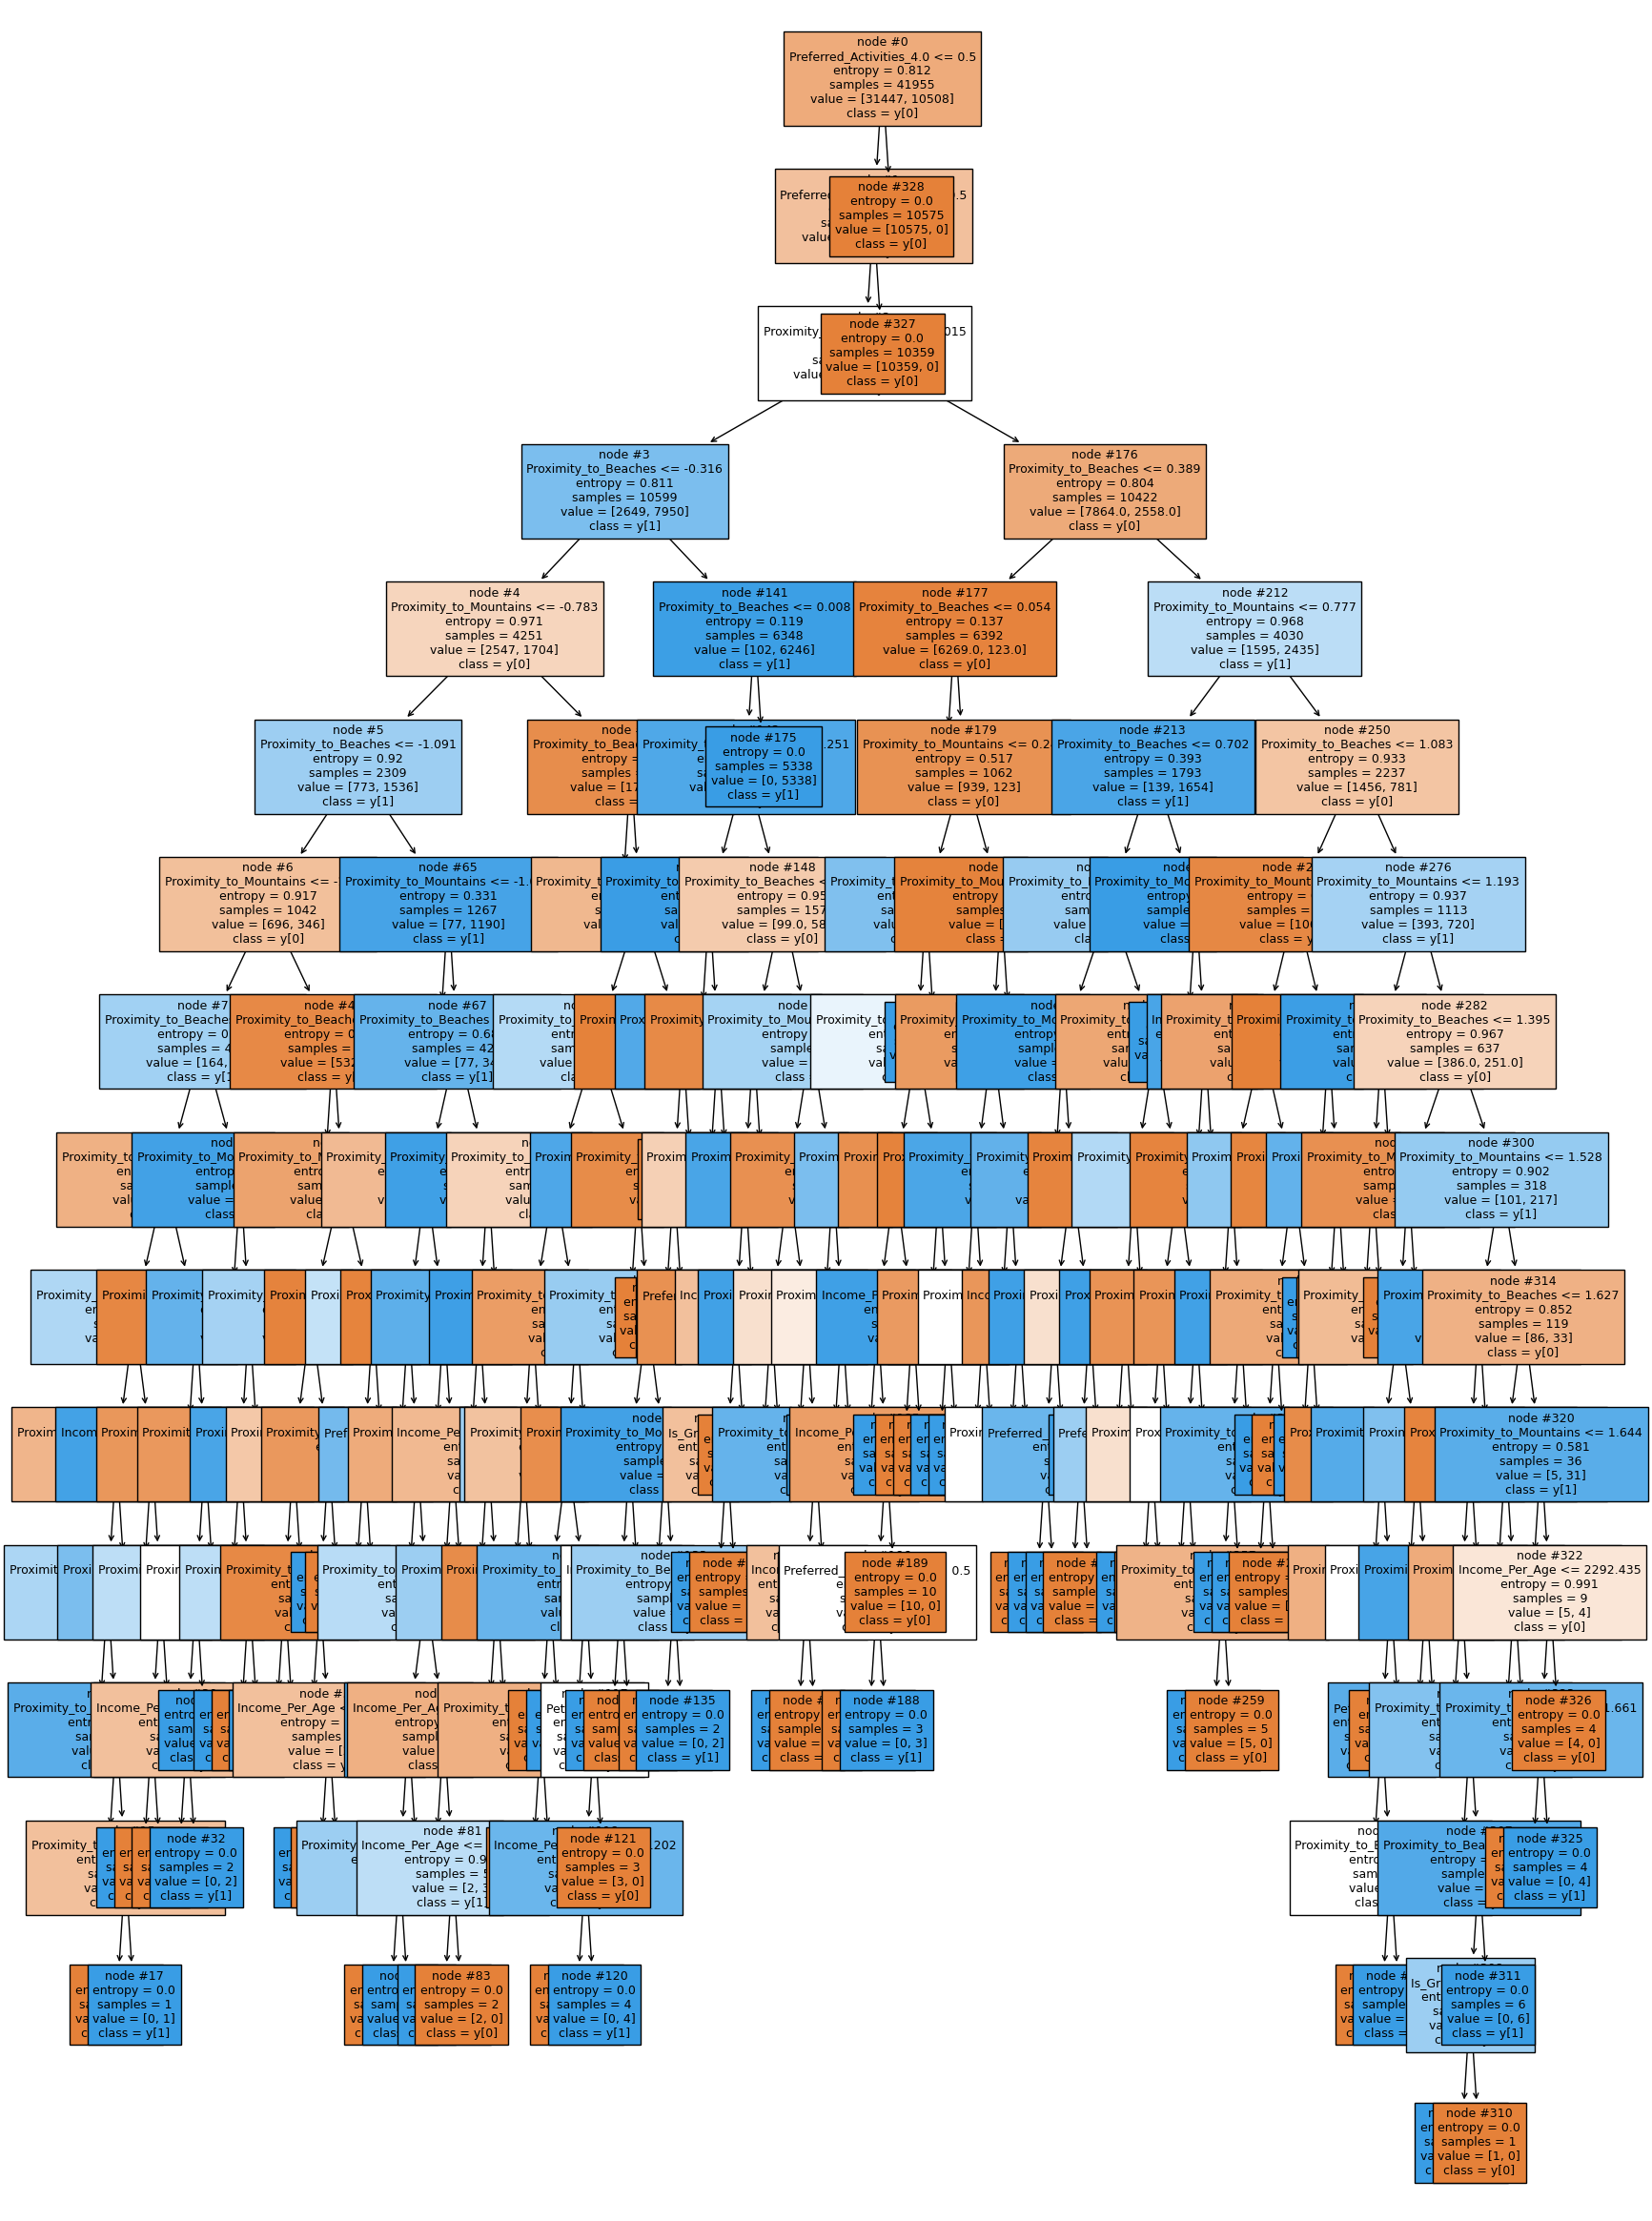

In [ ]:
# Plot da árvore
feature_names = list(X_train.columns)

plt.figure(figsize=(20, 30))
tree.plot_tree(arvore_d, feature_names=feature_names, filled=True,
            fontsize=9, node_ids=True, class_names=True);

In [ ]:
# Instanciando o modelo de Árvore de Decisão com Poda
arvore_d1 = DecisionTreeClassifier(criterion="entropy", random_state=1, max_depth=3)

# Treinando o modelo
arvore_d1.fit(X_train, y_train)

# Avaliando o modelo no conjunto de treino e teste
print("### Avaliação do Modelo de Árvore de Decisão ###")
arvore_d1_scores = performance_modelo_classificacao(arvore_d1, X_train, X_test, y_train, y_test)

### Avaliação do Modelo de Árvore de Decisão ###
Acurácia na base de Treino: 0.8759
Acurácia na base de Teste: 0.8751

Recall na base de Treino: 0.7566
Recall na base de Teste: 0.7553

Precisão na base de Treino: 0.7501
Precisão na base de Teste: 0.7502

F1-Score na base de Treino: 0.7533
F1-Score na base de Teste: 0.7527


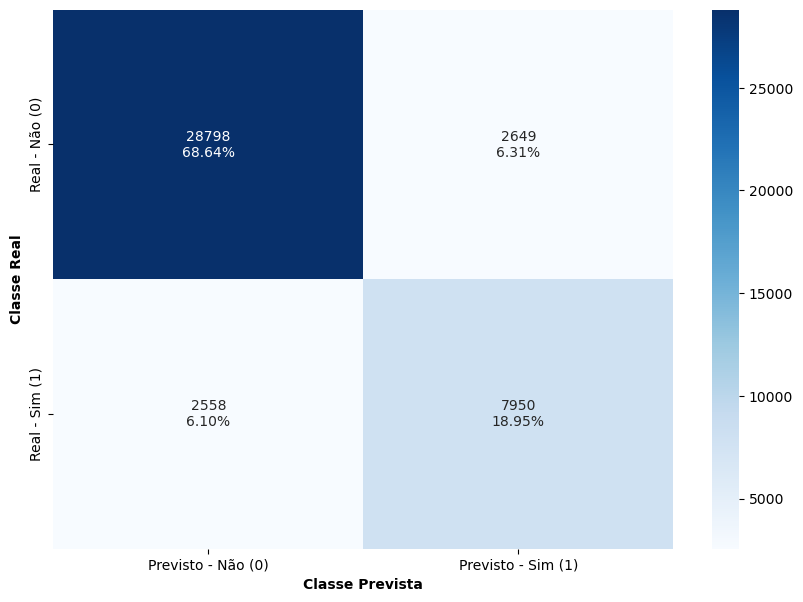

In [ ]:
# Matriz de Confusão de treino
matriz_confusao(arvore_d1, X_train, y_train)

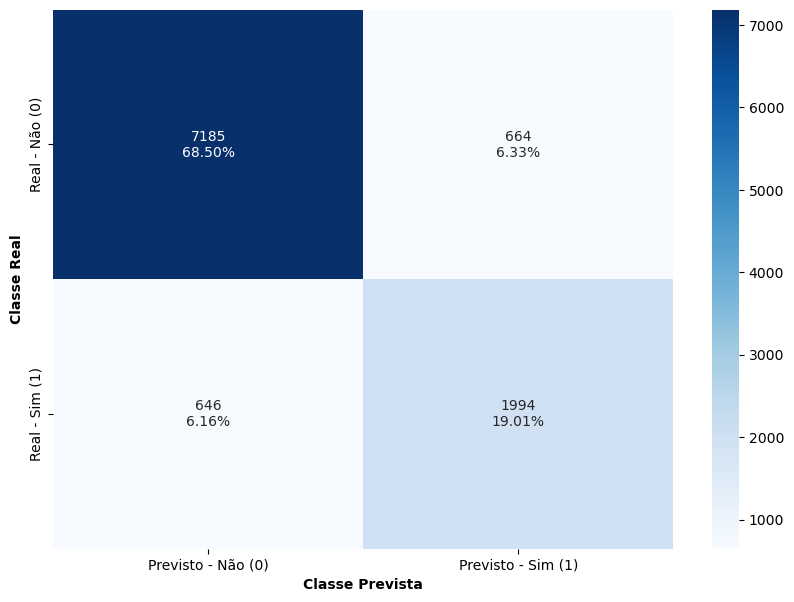

In [ ]:
# Matriz de Confusão de teste
matriz_confusao(arvore_d1, X_test, y_test)

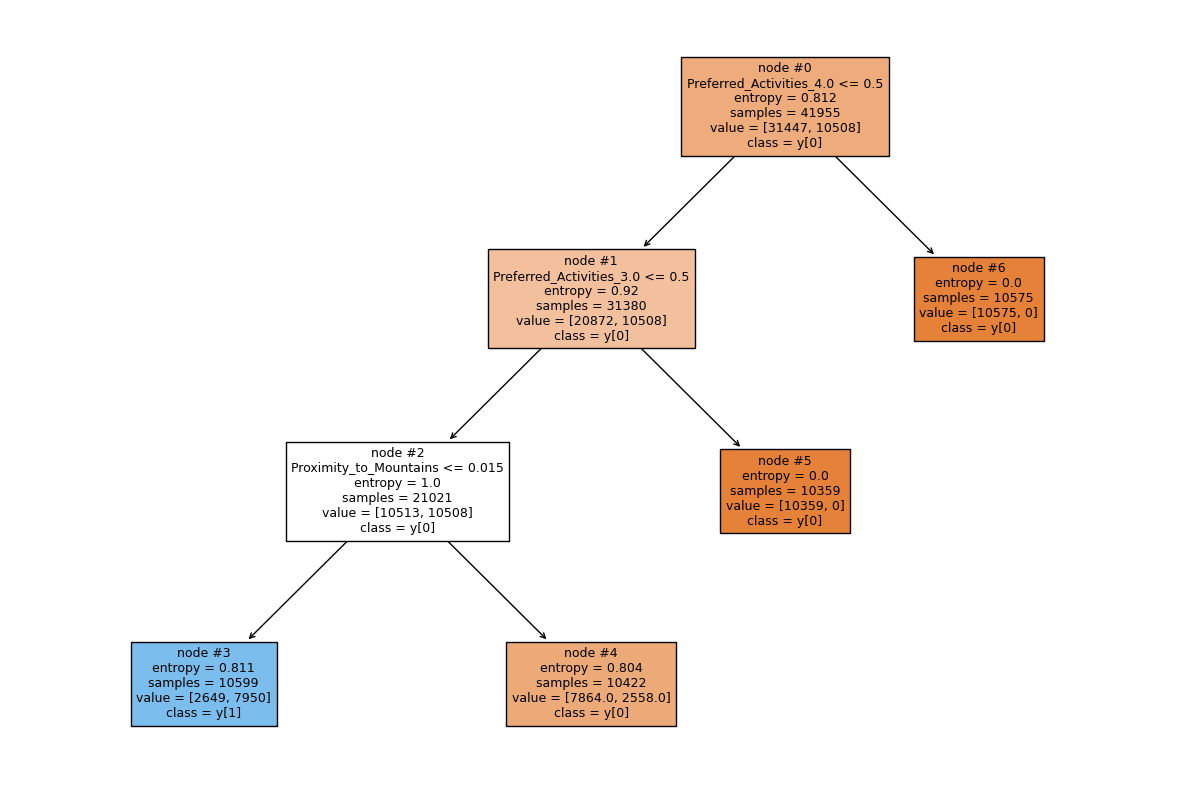

In [ ]:
feature_names = list(X_train.columns)

plt.figure(figsize=(15, 10))
tree.plot_tree(arvore_d1, feature_names=feature_names, filled=True,
            fontsize=9, node_ids=True, class_names=True);